Image shape: (403, 302)
Pixel values range: [0, 255]


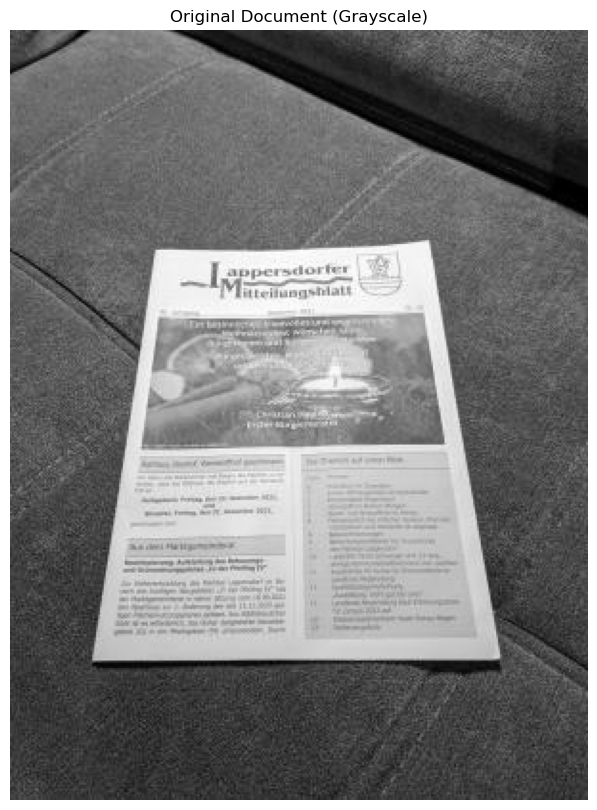

In [2]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Load document image
img = cv2.imread('data/document.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(f"Image shape: {img.shape}")
print(f"Pixel values range: [{img.min()}, {img.max()}]")

plt.imshow(img, cmap='gray')
plt.title('Original Document (Grayscale)')
plt.axis('off')
plt.show()

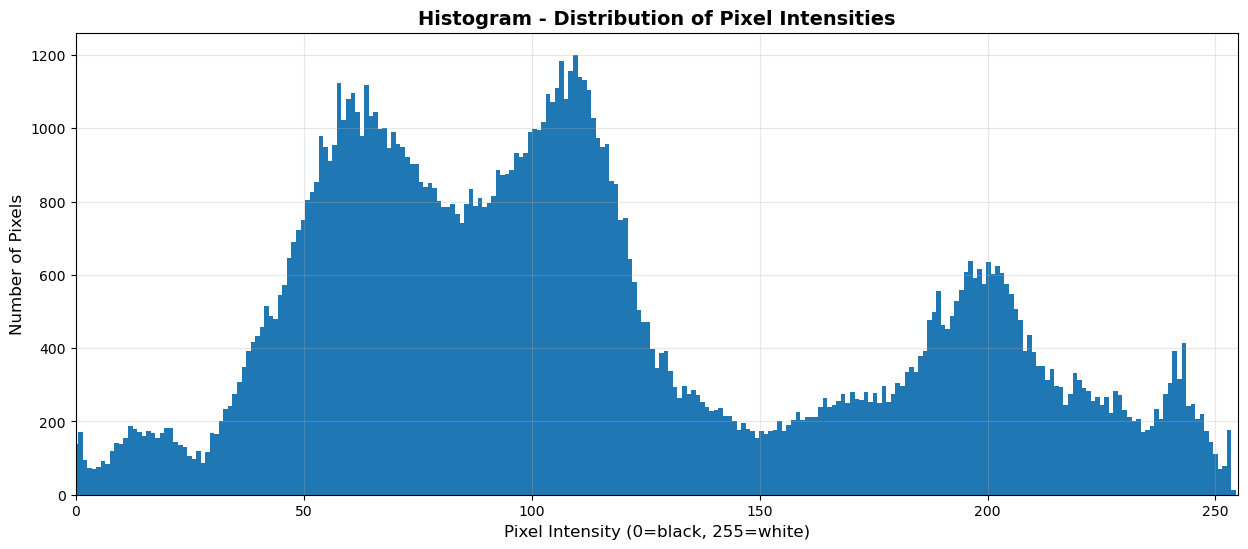


Total pixels: 121706
Histogram shape: (256,)

Peak values in histogram:
  Intensity 110: 1201 pixels
  Intensity 107: 1183 pixels
  Intensity 109: 1157 pixels


In [4]:
# Compute histogram - count pixels for each brightness level (0-255)
h = np.histogram(img, 256)

# Plot it
plt.figure(figsize=(15, 6))
plt.bar(h[1][0:-1], h[0], width=1.0, edgecolor='none')
plt.xlabel('Pixel Intensity (0=black, 255=white)', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)
plt.title('Histogram - Distribution of Pixel Intensities', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim([0, 255])
plt.show()

print(f"\nTotal pixels: {img.size}")
print(f"Histogram shape: {h[0].shape}")
print(f"\nPeak values in histogram:")
# Find top 3 peaks
top_peaks = np.argsort(h[0])[-3:][::-1]
for peak in top_peaks:
    print(f"  Intensity {peak}: {h[0][peak]} pixels")


In [7]:
#  OTSU THRESHOLDING ALGORITHM 

# Get image dimensions
rows, cols = img.shape

# Total number of pixels
num_pixels = rows * cols

print(f"Image size: {rows} x {cols}")
print(f"Total pixels: {num_pixels}")
print(f"\nStarting brute-force search for optimal threshold...")

# Initializations
best_wcv = 1e6  # Best within-class variance (start with huge number)
opt_th = None   # Optimal threshold (what we're looking for!)

# Try EVERY possible threshold from 0 to 255
for th in range(0, 256):
    
    # Split pixels into two classes based on current threshold
    # Foreground = text (dark pixels, < threshold)
    foreground = img[img < th]
    # Background = paper (bright pixels, >= threshold)
    background = img[img >= th]
    
    # Skip if either class is empty (can't compute variance)
    if len(foreground) == 0 or len(background) == 0:
        continue
    
    # Compute class weights (what fraction of pixels in each class?)
    # omega = probability of pixel belonging to this class
    omega_f = len(foreground) / num_pixels
    omega_b = len(background) / num_pixels
    
    # Compute variance within each class
    # Lower variance = pixels in class are similar (good separation!)
    sigma2_f = np.var(foreground)
    sigma2_b = np.var(background)
    
    # Within-class variance (weighted sum)
    # We want to MINIMIZE this - means classes are compact/homogeneous
    wcv = omega_f * sigma2_f + omega_b * sigma2_b
    
    # Keep track of best threshold so far
    if wcv < best_wcv:
        best_wcv = wcv
        opt_th = th

print(f"\nOptimal threshold found: {opt_th}")
print(f"Best within-class variance: {best_wcv:.2f}")

Image size: 403 x 302
Total pixels: 121706

Starting brute-force search for optimal threshold...

Optimal threshold found: 140
Best within-class variance: 867.71


Optimal threshold: 140
Binary image dtype: bool
Unique values: [False  True]


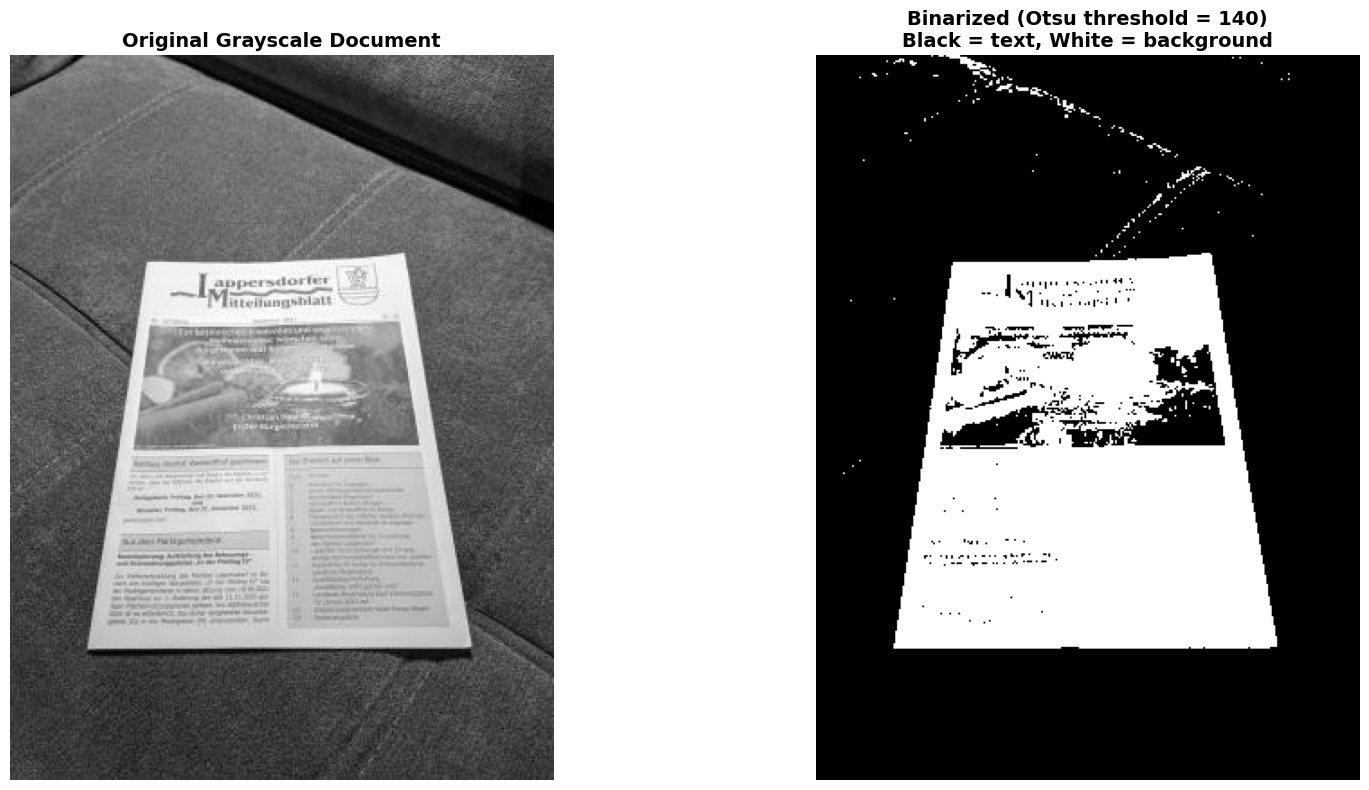

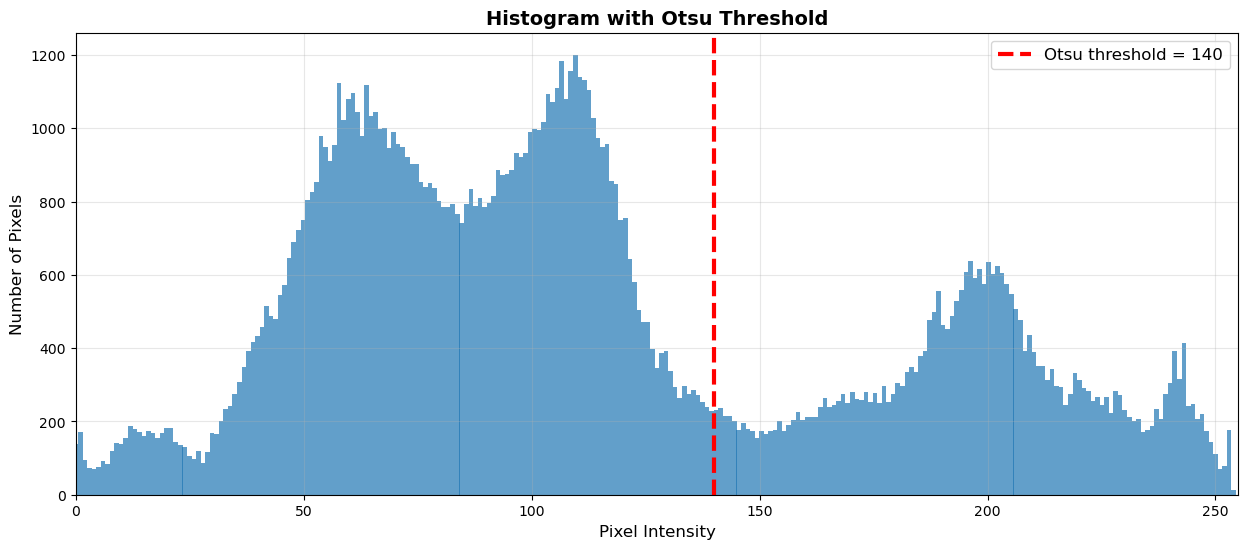


 Statistics:
Pixels classified as text (black): 86563 (71.1%)
Pixels classified as background (white): 35143 (28.9%)


In [8]:
# APPLY THRESHOLD AND VISUALIZE 

# Create binary image using optimal threshold
# Pixels >= threshold become white (True/1)
# Pixels < threshold become black (False/0)
binary = img >= opt_th

print(f"Optimal threshold: {opt_th}")
print(f"Binary image dtype: {binary.dtype}")
print(f"Unique values: {np.unique(binary)}")

# Show original vs binarized
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Grayscale Document', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(binary, cmap='gray')
axes[1].set_title(f'Binarized (Otsu threshold = {opt_th})\nBlack = text, White = background', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Show histogram with threshold line
plt.figure(figsize=(15, 6))
plt.bar(h[1][0:-1], h[0], width=1.0, edgecolor='none', alpha=0.7)
plt.axvline(x=opt_th, color='red', linestyle='--', linewidth=3, label=f'Otsu threshold = {opt_th}')
plt.xlabel('Pixel Intensity', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)
plt.title('Histogram with Otsu Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([0, 255])
plt.show()

print(f"\n Statistics:")
print(f"Pixels classified as text (black): {np.sum(~binary)} ({np.sum(~binary)/num_pixels*100:.1f}%)")
print(f"Pixels classified as background (white): {np.sum(binary)} ({np.sum(binary)/num_pixels*100:.1f}%)")

 Comparing our implementation with OpenCV's Otsu

Our implementation:     threshold = 140
OpenCV implementation:  threshold = 139.0
Difference: 1.0

 See difference due to rounding or details


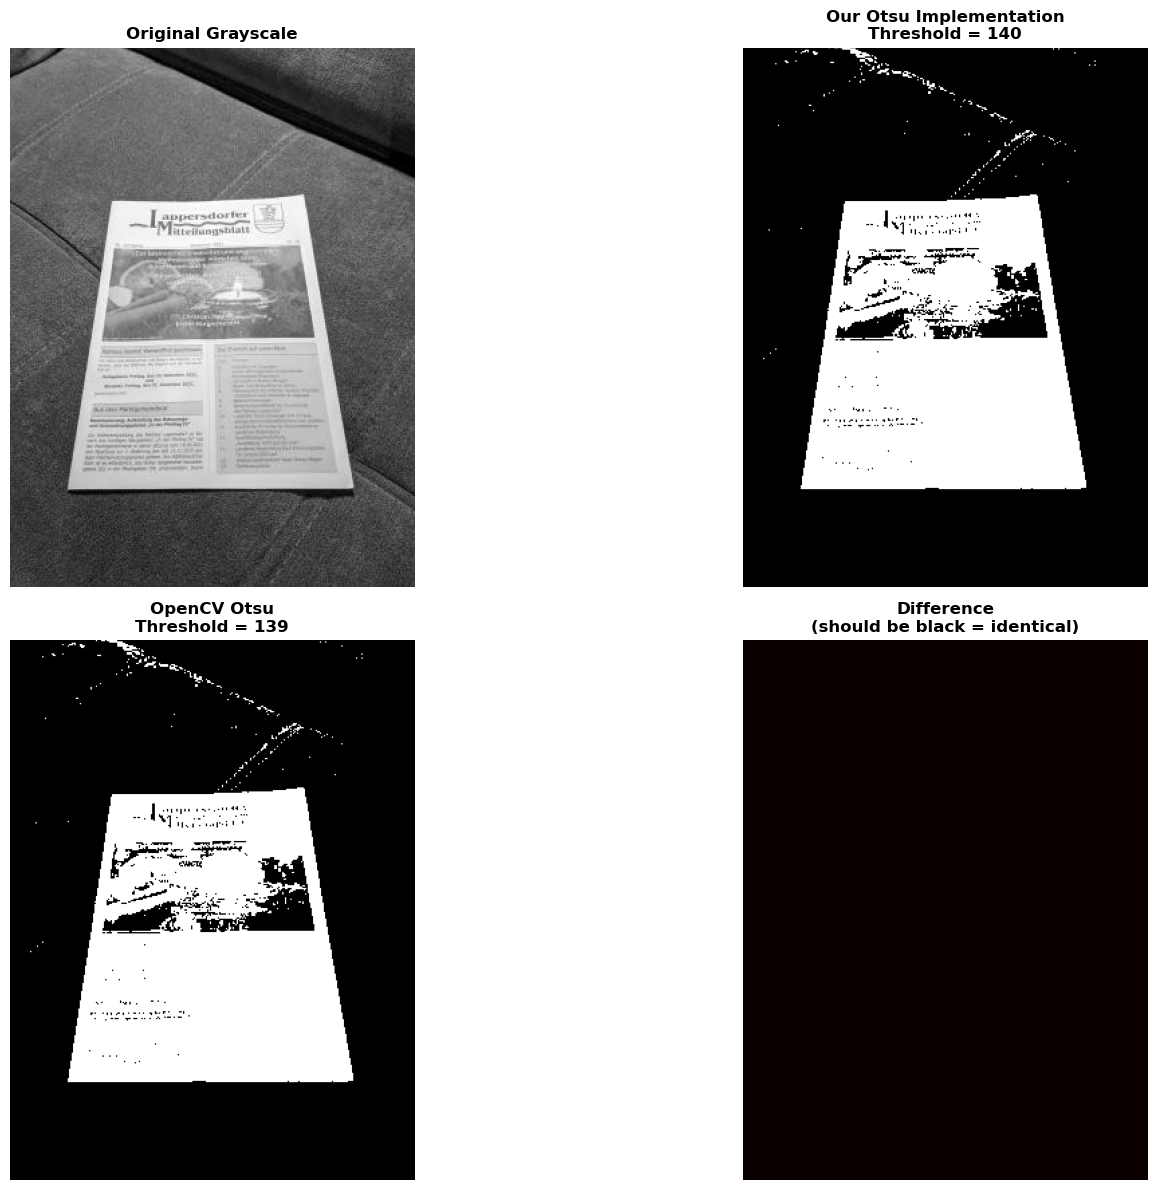


 Difference pixels: 0/121706
Accuracy: 100.00%


In [11]:
#  COMPARISON WITH OPENCV'S BUILT-IN OTSU 

print(" Comparing our implementation with OpenCV's Otsu\n")

# OpenCV has built-in Otsu implementation
# cv2.threshold with cv2.THRESH_OTSU flag
opencv_threshold, binary_opencv = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Our implementation:     threshold = {opt_th}")
print(f"OpenCV implementation:  threshold = {opencv_threshold}")
print(f"Difference: {abs(opt_th - opencv_threshold)}")

if opt_th == opencv_threshold:
    print("\n Implementation is correct!")
else:
    print("\n See difference due to rounding or details")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Original
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Grayscale', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Our Otsu
axes[0, 1].imshow(binary, cmap='gray')
axes[0, 1].set_title(f'Our Otsu Implementation\nThreshold = {opt_th}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# OpenCV Otsu
axes[1, 0].imshow(binary_opencv, cmap='gray')
axes[1, 0].set_title(f'OpenCV Otsu\nThreshold = {int(opencv_threshold)}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Difference (should be minimal or zero)
difference = np.abs(binary.astype(int) - (binary_opencv.astype(int) // 255))
axes[1, 1].imshow(difference, cmap='hot')
axes[1, 1].set_title(f'Difference\n(should be black = identical)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n Difference pixels: {np.sum(difference)}/{num_pixels}")
print(f"Accuracy: {(1 - np.sum(difference)/num_pixels) * 100:.2f}%")

OTSU ALGORITHM ANALYSIS

 Question 1: Is the histogram bimodal?

Number of significant peaks found: 10
Main peak 1 (background): intensity ~110 (1201 pixels)
Main peak 2 (text): intensity ~58 (1124 pixels)

 YES, the histogram appears bimodal!
Two clear peaks = ideal for Otsu algorithm

 Question 2: Manual threshold selection

If choosing manually, I'd pick around: 84
(halfway between the two peaks)
Otsu found: 140
Difference: 56

 Question 3: Quality of text binarization

Text pixels (foreground): mean = 81.7, std = 30.0
Background pixels: mean = 198.0, std = 28.1
Separation (contrast): 116.4

 binarization - strong separation between text and background


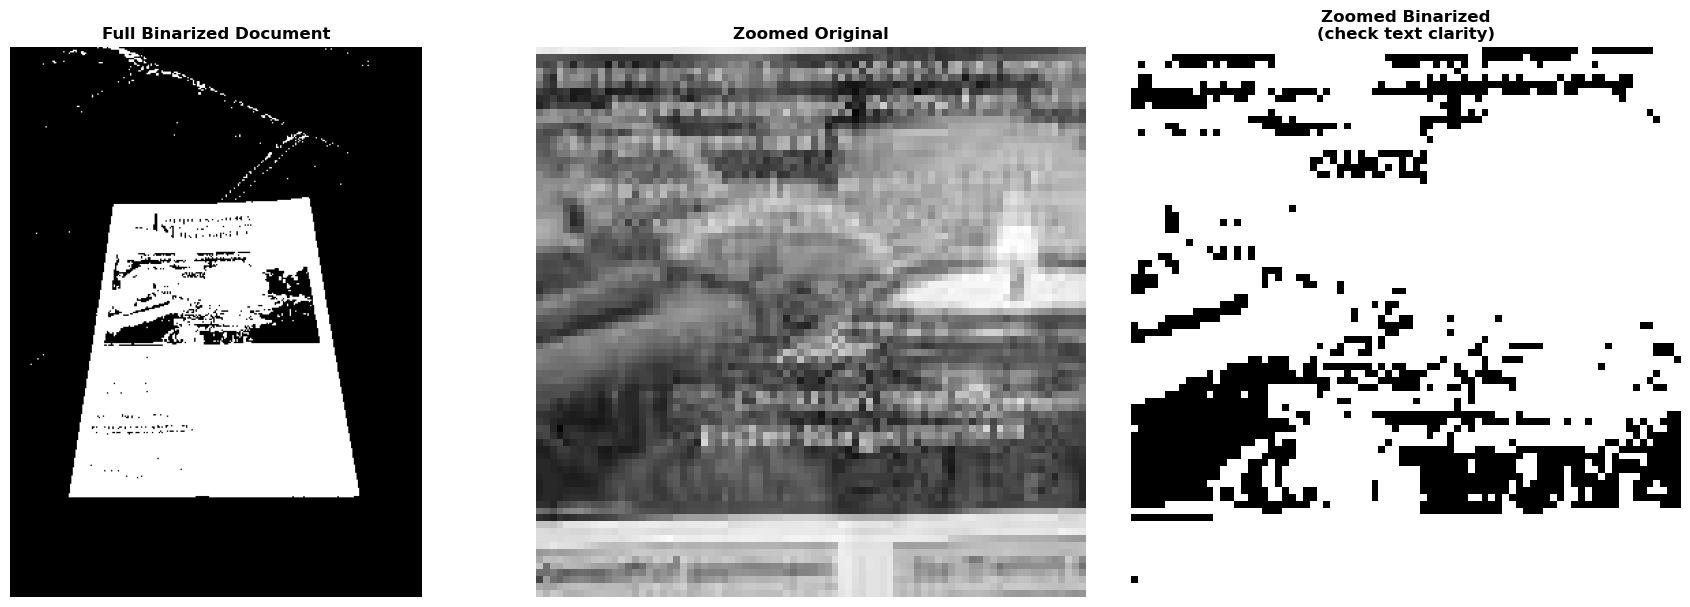


ANALYSIS COMPLETE!


In [13]:
#  DETAILED ANALYSIS 


print("OTSU ALGORITHM ANALYSIS")


# Question 1: Is histogram bimodal?
print("\n Question 1: Is the histogram bimodal?\n")

# Find peaks in histogram
from scipy.signal import find_peaks

peaks, properties = find_peaks(h[0], height=100, distance=20)
peak_heights = h[0][peaks]
sorted_peaks = peaks[np.argsort(peak_heights)[::-1]]

print(f"Number of significant peaks found: {len(sorted_peaks)}")
if len(sorted_peaks) >= 2:
    print(f"Main peak 1 (background): intensity ~{sorted_peaks[0]} ({h[0][sorted_peaks[0]]} pixels)")
    print(f"Main peak 2 (text): intensity ~{sorted_peaks[1]} ({h[0][sorted_peaks[1]]} pixels)")
    print("\n YES, the histogram appears bimodal!")
    print("Two clear peaks = ideal for Otsu algorithm")
else:
    print("\n Histogram might not be clearly bimodal")

# Question 2: What threshold would you choose manually?
print("\n" + "="*60)
print(" Question 2: Manual threshold selection\n")

# Typically, you'd choose somewhere between the two peaks
if len(sorted_peaks) >= 2:
    manual_estimate = (sorted_peaks[0] + sorted_peaks[1]) // 2
    print(f"If choosing manually, I'd pick around: {manual_estimate}")
    print(f"(halfway between the two peaks)")
    print(f"Otsu found: {opt_th}")
    print(f"Difference: {abs(manual_estimate - opt_th)}")
    
# Question 3: Is binarization good?
print("\n" + "="*60)
print(" Question 3: Quality of text binarization\n")

# Check contrast and clarity
foreground_pixels = img[~binary]
background_pixels = img[binary]

print(f"Text pixels (foreground): mean = {np.mean(foreground_pixels):.1f}, std = {np.std(foreground_pixels):.1f}")
print(f"Background pixels: mean = {np.mean(background_pixels):.1f}, std = {np.std(background_pixels):.1f}")
print(f"Separation (contrast): {np.mean(background_pixels) - np.mean(foreground_pixels):.1f}")

separation = np.mean(background_pixels) - np.mean(foreground_pixels)
if separation > 50:
    print("\n binarization - strong separation between text and background")
else:
    print("\n Weak separation - might struggle with some text")

# Visualize some zoomed regions to check quality
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Full image
axes[0].imshow(binary, cmap='gray')
axes[0].set_title('Full Binarized Document', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Zoom on text region (adjust coordinates based on your image)
zoom_y, zoom_x = 150, 100
zoom_size = 80
axes[1].imshow(img[zoom_y:zoom_y+zoom_size, zoom_x:zoom_x+zoom_size], cmap='gray')
axes[1].set_title('Zoomed Original', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(binary[zoom_y:zoom_y+zoom_size, zoom_x:zoom_x+zoom_size], cmap='gray')
axes[2].set_title('Zoomed Binarized\n(check text clarity)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

In [14]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

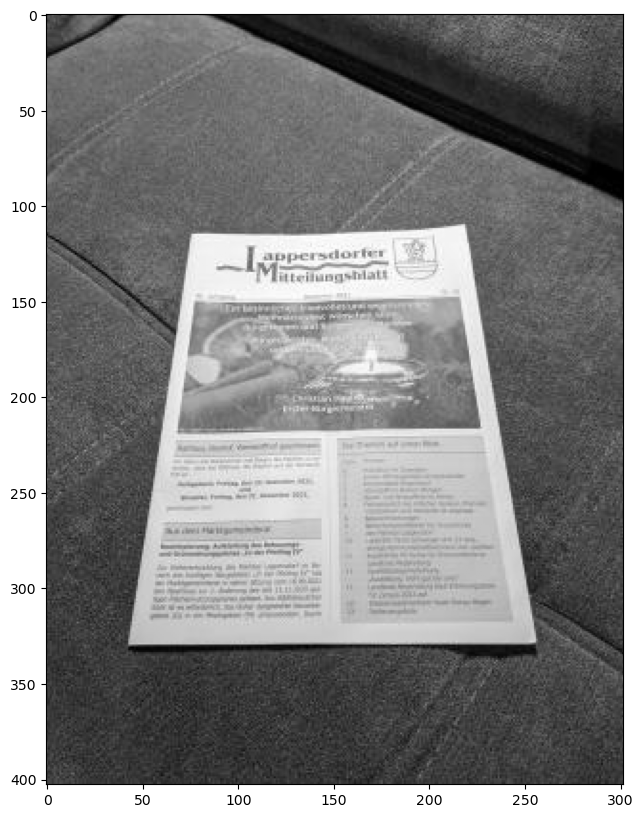

In [16]:
img = cv2.imread('data/document.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

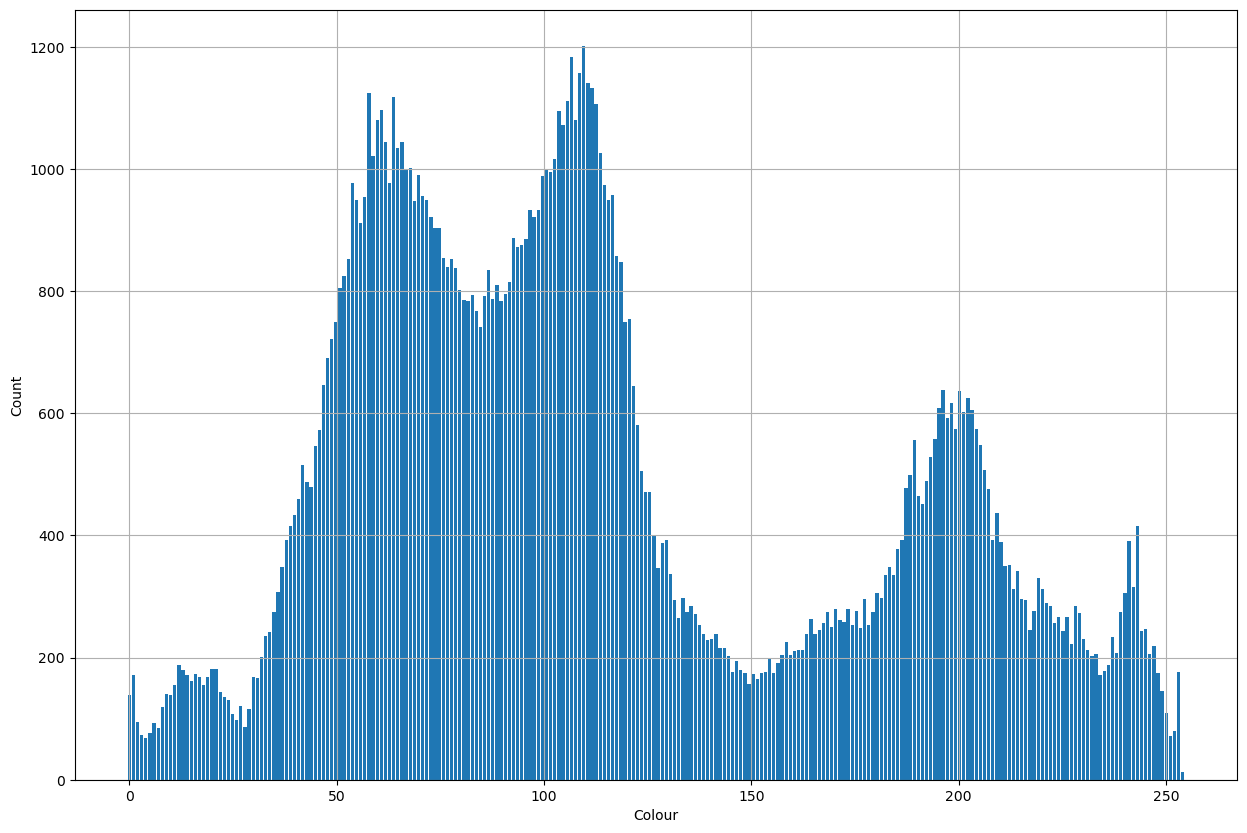

In [17]:
h = np.histogram(img, 256)
plt.bar(h[1][0:-1], h[0])
plt.xlabel('Colour'), plt.ylabel('Count')
plt.grid(True)